In [1]:
import pickle
import json
import numpy as np
import pandas as pd
from keplergl import KeplerGl
import datetime
from shapely.geometry import shape
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Load NYC GeoJSON and filter to Manhattan only
with open('data/nyc-zip-code-tabulation-areas-polygons.geojson', 'r') as f:
    nyc_geojson = json.load(f)

MANHATTAN_ZIP_CODES = ['10002', '10003', '10005', '10006', '10007', '10009', 
                    '10010', '10011', '10012', '10013', '10014', '10038']

# Filter to only include Manhattan zip codes
manhattan_geojson = {
    'type': 'FeatureCollection',
    'features': [
        feature for feature in nyc_geojson['features']
        if feature['properties'].get('postalCode') in MANHATTAN_ZIP_CODES
    ]
}

print(f"Loaded {len(manhattan_geojson['features'])} Manhattan regions out of {len(nyc_geojson['features'])} total NYC regions")

Loaded 12 Manhattan regions out of 262 total NYC regions


In [3]:
# Extract centroids from Manhattan regions
region_to_zip = {i: zc for i, zc in enumerate(MANHATTAN_ZIP_CODES)}
zip_to_region = {zc: i for i, zc in enumerate(MANHATTAN_ZIP_CODES)}

region_centroids = {}
manhattan_features = {}

for feature in manhattan_geojson['features']:
    postal = feature['properties']['postalCode']
    region_idx = zip_to_region[postal]
    manhattan_features[region_idx] = feature
    
    geom = shape(feature['geometry'])
    centroid = geom.centroid
    region_centroids[region_idx] = (centroid.x, centroid.y)

In [4]:
with open('saved_files/reb_flows_mode2_1200cars_nyc_man_south.pkl', 'rb') as f:
    flow_data = pickle.load(f)

In [5]:
# Time settings
BASE_TIME = datetime.datetime(2013, 3, 8, 19, 0, 0)
INTERVAL_MINUTES = 3

def timestep_to_datetime(t):
    dt = BASE_TIME + datetime.timedelta(minutes=t * INTERVAL_MINUTES)
    return dt.strftime('%Y-%m-%d %H:%M:%S')

In [6]:
# Create rebalancing flow DataFrame
def create_flow_df(flow_data, agent_id, region_centroids, edges):
    flows = flow_data['agent_reb_flows'][agent_id]
    num_timesteps, num_edges = flows.shape
    
    records = []
    for t in range(num_timesteps):
        for edge_idx, (origin, dest) in enumerate(edges):
            flow_value = flows[t, edge_idx]
            origin_lon, origin_lat = region_centroids[origin]
            dest_lon, dest_lat = region_centroids[dest]
                
            records.append({
                'origin_lon': origin_lon,
                'origin_lat': origin_lat,
                'dest_lon': dest_lon,
                'dest_lat': dest_lat,
                'origin_region': origin,
                'dest_region': dest,
                'origin_zip': region_to_zip[origin],
                'dest_zip': region_to_zip[dest],
                'flow': float(flow_value),
                'timestep': t,
                'datetime': timestep_to_datetime(t),
                'agent': agent_id
            })
    
    return pd.DataFrame(records)

df_agent0 = create_flow_df(flow_data, 0, region_centroids, flow_data['edges'])

In [7]:
# Kepler.gl configuration for rebalancing flows
config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 40.71,
            'longitude': -74.00,
            'zoom': 12.5,
            'pitch': 55,
            'bearing': -50,
            'dragRotate': True
        },
        'visState': {
            'filters': [{
                'dataId': ['Agent 0 Rebalancing Flows'],
                'id': 'time-filter',
                'name': ['datetime'],
                'type': 'timeRange',
                'value': [df_agent0['datetime'].min(), df_agent0['datetime'].max()],
                'enlarged': True,
                'plotType': 'histogram',
                'animationWindow': 'free',
                'speed': 1,
                'yAxis': {'type': 'value', 'domain': [0, 179]}
            }],
            'layers': [
                {
                    'type': 'geojson',
                    'config': {
                        'dataId': 'Manhattan Zip Code Areas',
                        'label': 'Manhattan Regions',
                        'color': [96, 96, 96],
                        'columns': {'geojson': '_geojson'},
                        'isVisible': True,
                        'visConfig': {
                            'opacity': 0.3,
                            'strokeOpacity': 0.8,
                            'thickness': 1,
                            'strokeColor': [0, 0, 0],
                            'stroked': True,
                            'filled': True,
                            'enable3d': False,
                            'wireframe': True
                        }
                    }
                },
                {
                    'type': 'arc',
                    'config': {
                        'dataId': 'Agent 0 Rebalancing Flows',
                        'label': 'Rebalancing Arcs',
                        'color': [255, 255, 0],
                        'columns': {
                            'lat0': 'origin_lat',
                            'lng0': 'origin_lon',
                            'lat1': 'dest_lat',
                            'lng1': 'dest_lon'
                        },
                        'isVisible': True,
                        'visConfig': {
                            'opacity': 0.8,
                            'thickness': 2,
                            'colorRange': {
                                'name': 'Custom Yellow to Blue',
                                'type': 'sequential',
                                'category': 'Custom',
                                'colors': ['#FFFF00', '#0000FF']
                            },
                            'sizeRange': [0, 10],
                            'targetColor': [0, 0, 255]
                        },
                        'sizeField': {'name': 'flow', 'type': 'real'},
                        'sizeScale': 'linear'
                    },
                    'visualChannels': {
                        'sizeField': {'name': 'flow', 'type': 'real'},
                        'sizeScale': 'linear'
                    }
                }
            ]
        }
    }
}

manhattan_animated = KeplerGl(height=500, config=config)
manhattan_animated.add_data(data=manhattan_geojson, name='Manhattan Zip Code Areas')
manhattan_animated.add_data(data=df_agent0, name='Agent 0 Rebalancing Flows')
manhattan_animated

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 40.71, 'longitude': -74.0, 'zoom': 12.5,…

In [8]:
# Export rebalancing map
manhattan_animated.save_to_html(file_name='manhattan_rebalancing_flows.html')

Map saved to manhattan_rebalancing_flows.html!


In [9]:
# Create Agent 1 rebalancing flow DataFrame
df_agent1 = create_flow_df(flow_data, 1, region_centroids, flow_data['edges'])

In [10]:
# Kepler.gl configuration for Agent 1 rebalancing flows
config_agent1 = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 40.71,
            'longitude': -74.00,
            'zoom': 12.5,
            'pitch': 55,
            'bearing': -50,
            'dragRotate': True
        },
        'visState': {
            'filters': [{
                'dataId': ['Agent 1 Rebalancing Flows'],
                'id': 'time-filter',
                'name': ['datetime'],
                'type': 'timeRange',
                'value': [df_agent1['datetime'].min(), df_agent1['datetime'].max()],
                'enlarged': True,
                'plotType': 'histogram',
                'animationWindow': 'free',
                'speed': 1,
                'yAxis': {'type': 'value', 'domain': [0, 179]}
            }],
            'layers': [
                {
                    'type': 'geojson',
                    'config': {
                        'dataId': 'Manhattan Zip Code Areas',
                        'label': 'Manhattan Regions',
                        'color': [96, 96, 96],
                        'columns': {'geojson': '_geojson'},
                        'isVisible': True,
                        'visConfig': {
                            'opacity': 0.3,
                            'strokeOpacity': 0.8,
                            'thickness': 1,
                            'strokeColor': [0, 0, 0],
                            'stroked': True,
                            'filled': True,
                            'enable3d': False,
                            'wireframe': True
                        }
                    }
                },
                {
                    'type': 'arc',
                    'config': {
                        'dataId': 'Agent 1 Rebalancing Flows',
                        'label': 'Rebalancing Arcs',
                        'color': [255, 0, 255],
                        'columns': {
                            'lat0': 'origin_lat',
                            'lng0': 'origin_lon',
                            'lat1': 'dest_lat',
                            'lng1': 'dest_lon'
                        },
                        'isVisible': True,
                        'visConfig': {
                            'opacity': 0.8,
                            'thickness': 2,
                            'colorRange': {
                                'name': 'Custom Magenta to Cyan',
                                'type': 'sequential',
                                'category': 'Custom',
                                'colors': ['#FF00FF', '#00FFFF']
                            },
                            'sizeRange': [0, 10],
                            'targetColor': [0, 255, 255]
                        },
                        'sizeField': {'name': 'flow', 'type': 'real'},
                        'sizeScale': 'linear'
                    },
                    'visualChannels': {
                        'sizeField': {'name': 'flow', 'type': 'real'},
                        'sizeScale': 'linear'
                    }
                }
            ]
        }
    }
}

manhattan_animated_agent1 = KeplerGl(height=500, config=config_agent1)
manhattan_animated_agent1.add_data(data=manhattan_geojson, name='Manhattan Zip Code Areas')
manhattan_animated_agent1.add_data(data=df_agent1, name='Agent 1 Rebalancing Flows')
manhattan_animated_agent1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 40.71, 'longitude': -74.0, 'zoom': 12.5,…

In [11]:
# Export Agent 1 rebalancing map
manhattan_animated_agent1.save_to_html(file_name='manhattan_rebalancing_flows_agent1.html')

Map saved to manhattan_rebalancing_flows_agent1.html!


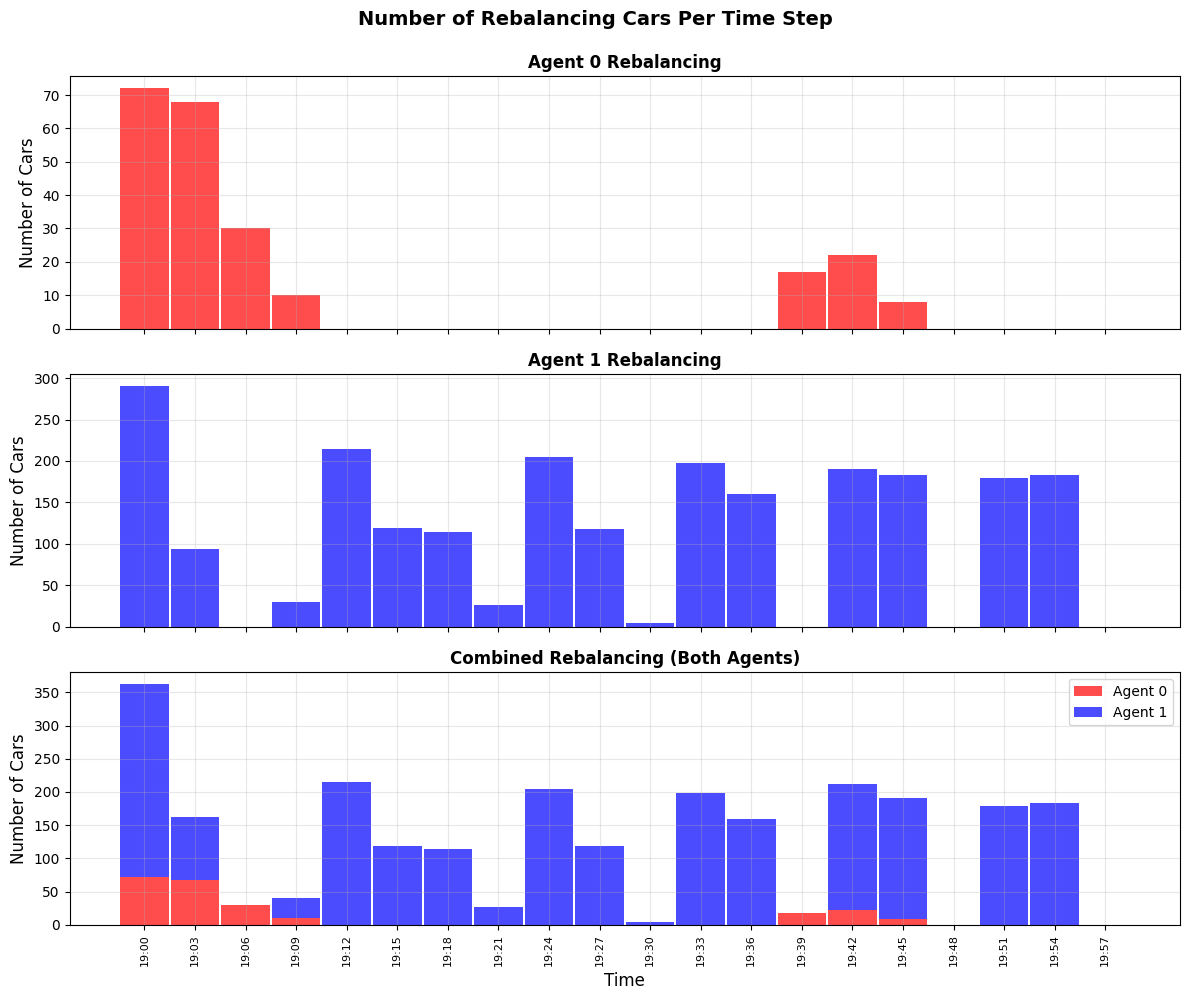

In [12]:
# Create histogram of number of rebalancing cars per timestep
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate total number of rebalancing cars per timestep for each agent
agent0_reb_per_timestep = flow_data['agent_reb_flows'][0].sum(axis=1)
agent1_reb_per_timestep = flow_data['agent_reb_flows'][1].sum(axis=1)

# Create time array (convert timesteps to actual datetime)
num_timesteps = len(agent0_reb_per_timestep)
time_points = [BASE_TIME + datetime.timedelta(minutes=t * INTERVAL_MINUTES) for t in range(num_timesteps)]

# Create the figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot for Agent 0 (Red)
axes[0].bar(time_points, agent0_reb_per_timestep, color='red', alpha=0.7, width=0.002)
axes[0].set_ylabel('Number of Cars', fontsize=12)
axes[0].set_title('Agent 0 Rebalancing', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot for Agent 1 (Blue)
axes[1].bar(time_points, agent1_reb_per_timestep, color='blue', alpha=0.7, width=0.002)
axes[1].set_ylabel('Number of Cars', fontsize=12)
axes[1].set_title('Agent 1 Rebalancing', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot for Combined (Stacked: Agent 0 in red, Agent 1 in blue)
axes[2].bar(time_points, agent0_reb_per_timestep, color='red', alpha=0.7, width=0.002, label='Agent 0')
axes[2].bar(time_points, agent1_reb_per_timestep, color='blue', alpha=0.7, width=0.002, 
            bottom=agent0_reb_per_timestep, label='Agent 1')
axes[2].set_xlabel('Time', fontsize=12)
axes[2].set_ylabel('Number of Cars', fontsize=12)
axes[2].set_title('Combined Rebalancing (Both Agents)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right')

# Format x-axis to show time nicely with ticks at each timestep
for ax in axes:
    ax.set_xticks(time_points)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='center', fontsize=8)

# Add overall title
fig.suptitle('Number of Rebalancing Cars Per Time Step', fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

## Aggregate Rebalancing Strategy Comparison

Compare the overall rebalancing strategies of both agents across all timesteps.

In [13]:
# Create Origin-Destination (OD) matrices for total rebalancing flows
# Sum flows over all timesteps
agent0_flows = flow_data['agent_reb_flows'][0]  # shape: (timesteps, edges)
agent1_flows = flow_data['agent_reb_flows'][1]

# Aggregate flows over time
agent0_total_flows = agent0_flows.sum(axis=0)
agent1_total_flows = agent1_flows.sum(axis=0)

# Create OD matrices (region x region)
num_regions = len(MANHATTAN_ZIP_CODES)
od_matrix_agent0 = np.zeros((num_regions, num_regions))
od_matrix_agent1 = np.zeros((num_regions, num_regions))

for edge_idx, (origin, dest) in enumerate(flow_data['edges']):
    od_matrix_agent0[origin, dest] = agent0_total_flows[edge_idx]
    od_matrix_agent1[origin, dest] = agent1_total_flows[edge_idx]

# Calculate difference
od_matrix_diff = od_matrix_agent0 - od_matrix_agent1

print(f"Agent 0 total rebalancing vehicles: {agent0_total_flows.sum():.1f}")
print(f"Agent 1 total rebalancing vehicles: {agent1_total_flows.sum():.1f}")

Agent 0 total rebalancing vehicles: 227.0
Agent 1 total rebalancing vehicles: 2308.0


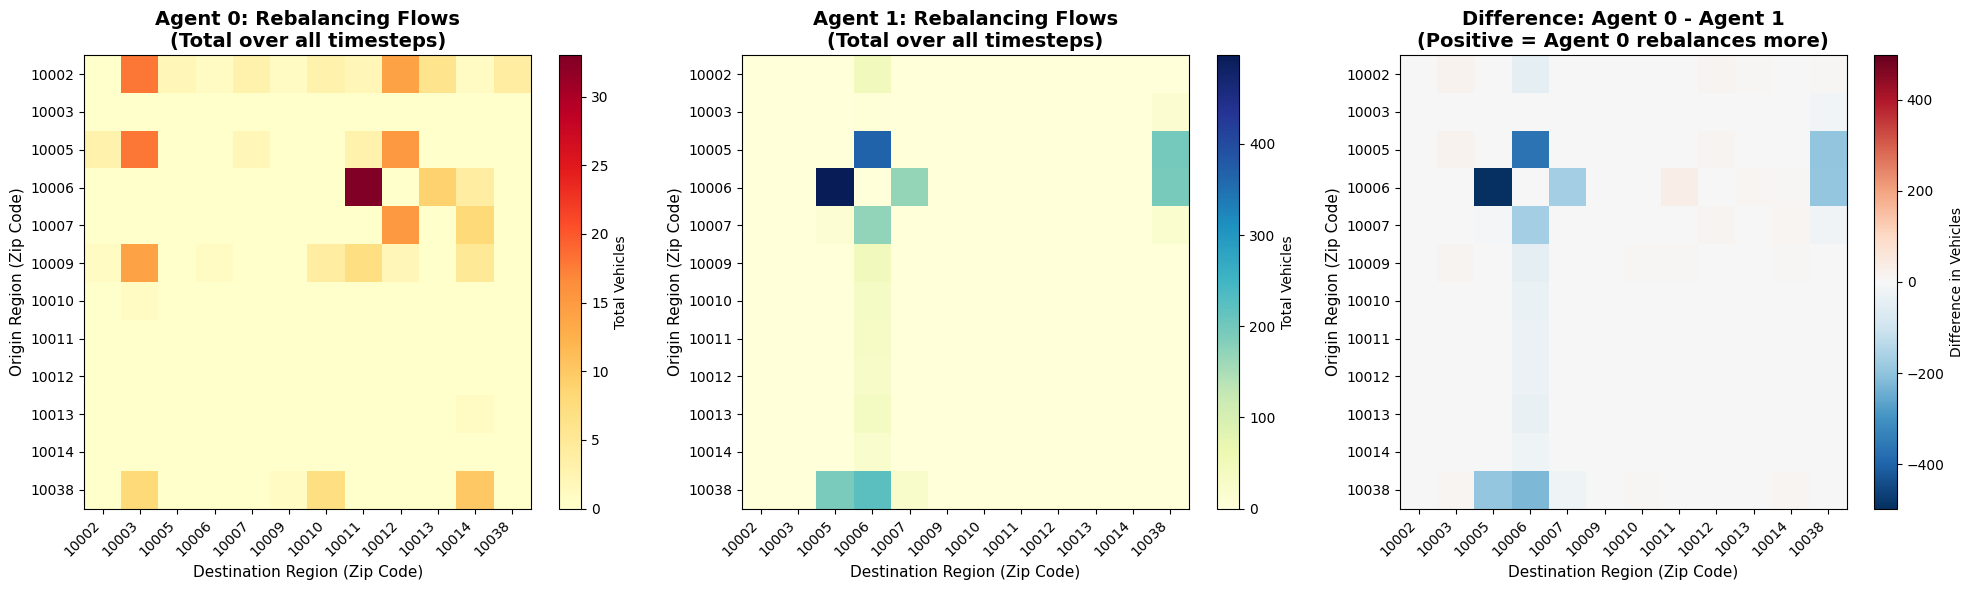

In [14]:
# Plot Origin-Destination Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Agent 0 OD Matrix
im0 = axes[0].imshow(od_matrix_agent0, cmap='YlOrRd', aspect='auto')
axes[0].set_title('Agent 0: Rebalancing Flows\n(Total over all timesteps)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Destination Region (Zip Code)', fontsize=11)
axes[0].set_ylabel('Origin Region (Zip Code)', fontsize=11)
axes[0].set_xticks(range(num_regions))
axes[0].set_yticks(range(num_regions))
axes[0].set_xticklabels([region_to_zip[i] for i in range(num_regions)], rotation=45, ha='right')
axes[0].set_yticklabels([region_to_zip[i] for i in range(num_regions)])
plt.colorbar(im0, ax=axes[0], label='Total Vehicles')

# Agent 1 OD Matrix
im1 = axes[1].imshow(od_matrix_agent1, cmap='YlGnBu', aspect='auto')
axes[1].set_title('Agent 1: Rebalancing Flows\n(Total over all timesteps)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Destination Region (Zip Code)', fontsize=11)
axes[1].set_ylabel('Origin Region (Zip Code)', fontsize=11)
axes[1].set_xticks(range(num_regions))
axes[1].set_yticks(range(num_regions))
axes[1].set_xticklabels([region_to_zip[i] for i in range(num_regions)], rotation=45, ha='right')
axes[1].set_yticklabels([region_to_zip[i] for i in range(num_regions)])
plt.colorbar(im1, ax=axes[1], label='Total Vehicles')

# Difference OD Matrix (Agent 0 - Agent 1)
max_abs = max(abs(od_matrix_diff.min()), abs(od_matrix_diff.max()))
im2 = axes[2].imshow(od_matrix_diff, cmap='RdBu_r', aspect='auto', vmin=-max_abs, vmax=max_abs)
axes[2].set_title('Difference: Agent 0 - Agent 1\n(Positive = Agent 0 rebalances more)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Destination Region (Zip Code)', fontsize=11)
axes[2].set_ylabel('Origin Region (Zip Code)', fontsize=11)
axes[2].set_xticks(range(num_regions))
axes[2].set_yticks(range(num_regions))
axes[2].set_xticklabels([region_to_zip[i] for i in range(num_regions)], rotation=45, ha='right')
axes[2].set_yticklabels([region_to_zip[i] for i in range(num_regions)])
plt.colorbar(im2, ax=axes[2], label='Difference in Vehicles')

plt.tight_layout()
plt.show()

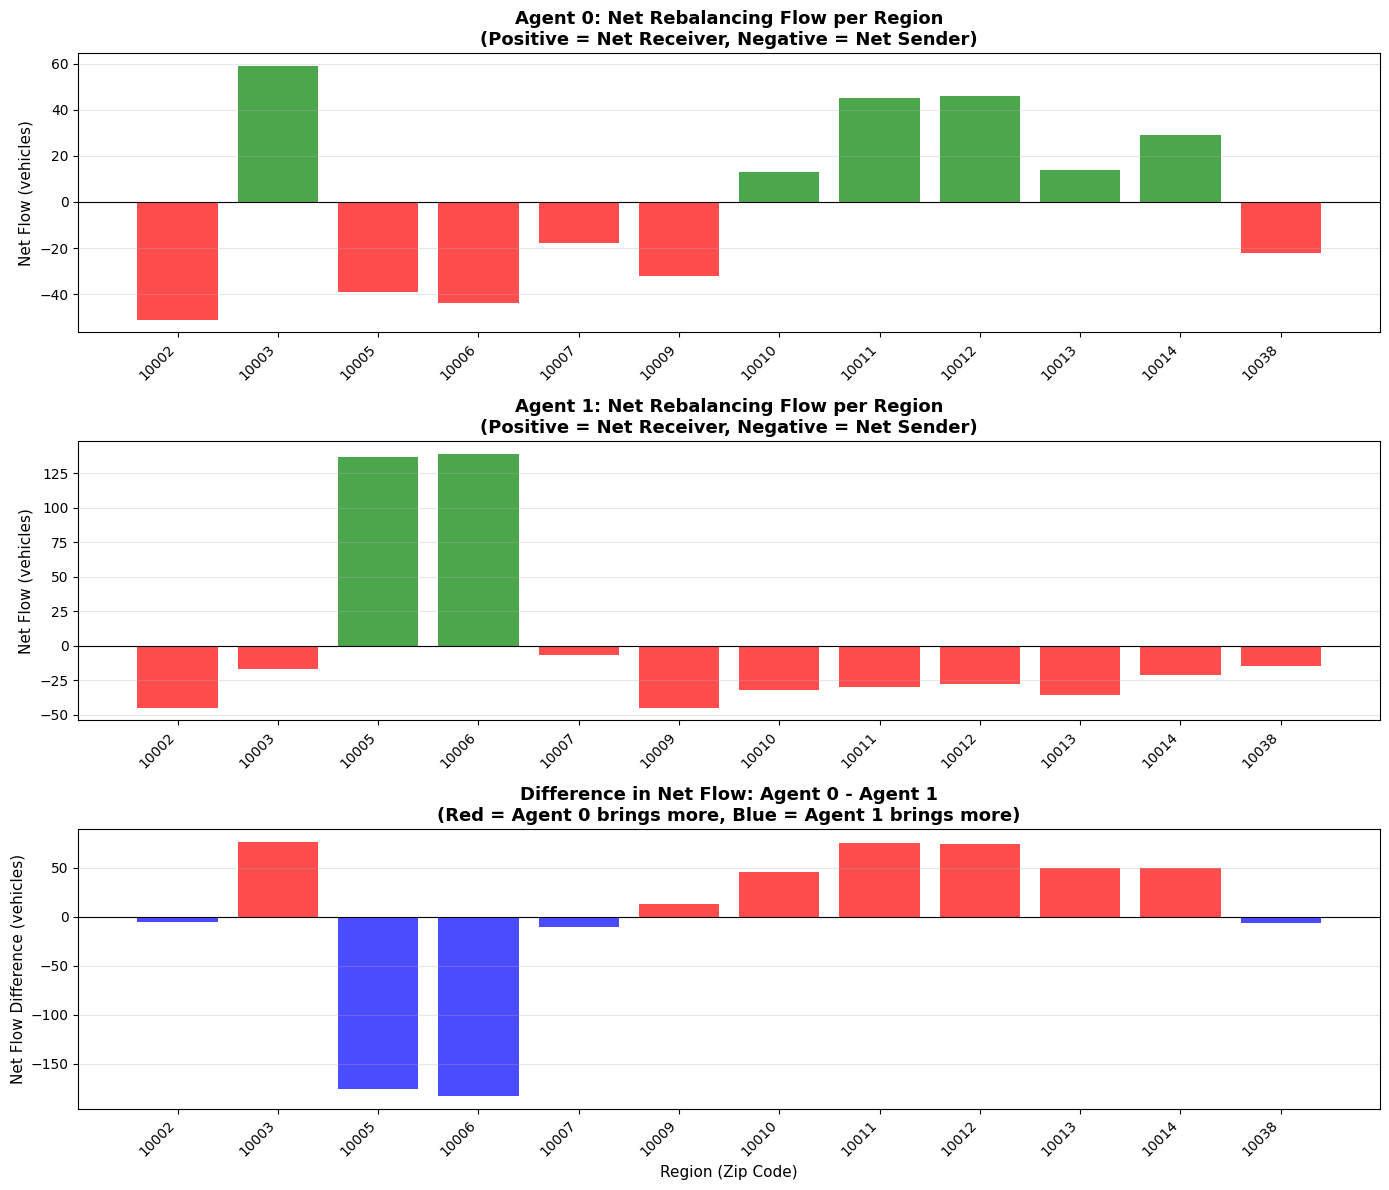

In [15]:
# Calculate net flows per region (inflow - outflow)
# Positive = net receiver, Negative = net sender
net_flow_agent0 = od_matrix_agent0.sum(axis=0) - od_matrix_agent0.sum(axis=1)
net_flow_agent1 = od_matrix_agent1.sum(axis=0) - od_matrix_agent1.sum(axis=1)

# Create DataFrame for plotting
net_flow_df = pd.DataFrame({
    'Zip Code': [region_to_zip[i] for i in range(num_regions)],
    'Agent 0 Net Flow': net_flow_agent0,
    'Agent 1 Net Flow': net_flow_agent1,
    'Difference': net_flow_agent0 - net_flow_agent1
})

# Plot net flows
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Agent 0 net flow
colors0 = ['red' if x < 0 else 'green' for x in net_flow_agent0]
axes[0].bar(range(num_regions), net_flow_agent0, color=colors0, alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_title('Agent 0: Net Rebalancing Flow per Region\n(Positive = Net Receiver, Negative = Net Sender)', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('Net Flow (vehicles)', fontsize=11)
axes[0].set_xticks(range(num_regions))
axes[0].set_xticklabels([region_to_zip[i] for i in range(num_regions)], rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Agent 1 net flow
colors1 = ['red' if x < 0 else 'green' for x in net_flow_agent1]
axes[1].bar(range(num_regions), net_flow_agent1, color=colors1, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title('Agent 1: Net Rebalancing Flow per Region\n(Positive = Net Receiver, Negative = Net Sender)', 
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('Net Flow (vehicles)', fontsize=11)
axes[1].set_xticks(range(num_regions))
axes[1].set_xticklabels([region_to_zip[i] for i in range(num_regions)], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

# Difference
net_diff = net_flow_agent0 - net_flow_agent1
colors_diff = ['blue' if x < 0 else 'red' for x in net_diff]
axes[2].bar(range(num_regions), net_diff, color=colors_diff, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[2].set_title('Difference in Net Flow: Agent 0 - Agent 1\n(Red = Agent 0 brings more, Blue = Agent 1 brings more)', 
                  fontsize=13, fontweight='bold')
axes[2].set_xlabel('Region (Zip Code)', fontsize=11)
axes[2].set_ylabel('Net Flow Difference (vehicles)', fontsize=11)
axes[2].set_xticks(range(num_regions))
axes[2].set_xticklabels([region_to_zip[i] for i in range(num_regions)], rotation=45, ha='right')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

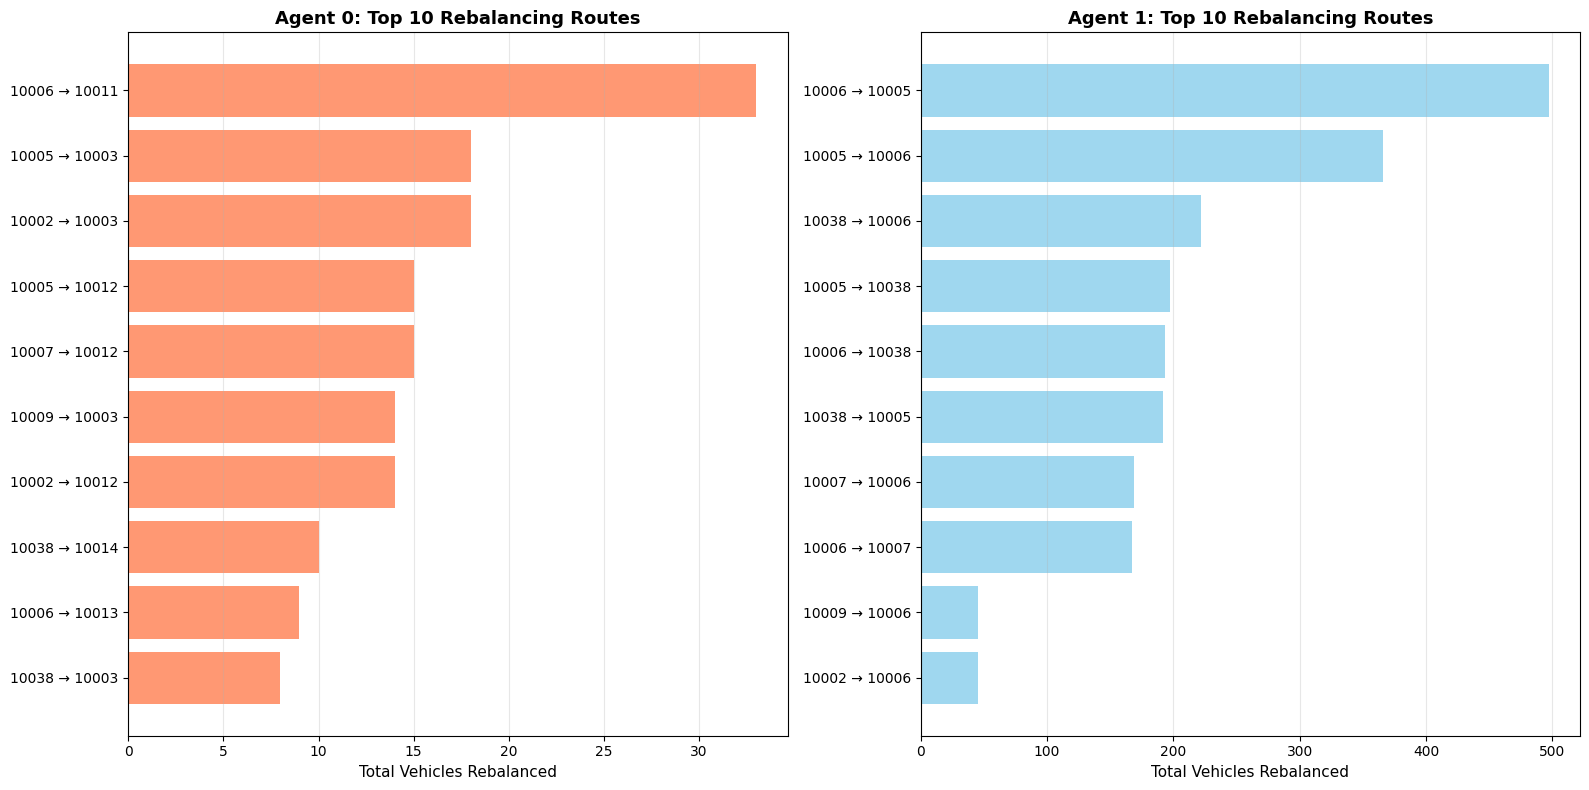

In [16]:
# Top rebalancing routes comparison
# Get top 10 routes for each agent
route_flows_agent0 = []
route_flows_agent1 = []

for edge_idx, (origin, dest) in enumerate(flow_data['edges']):
    if agent0_total_flows[edge_idx] > 0:
        route_flows_agent0.append({
            'route': f"{region_to_zip[origin]} → {region_to_zip[dest]}",
            'flow': agent0_total_flows[edge_idx],
            'origin': region_to_zip[origin],
            'dest': region_to_zip[dest]
        })
    if agent1_total_flows[edge_idx] > 0:
        route_flows_agent1.append({
            'route': f"{region_to_zip[origin]} → {region_to_zip[dest]}",
            'flow': agent1_total_flows[edge_idx],
            'origin': region_to_zip[origin],
            'dest': region_to_zip[dest]
        })

df_routes_agent0 = pd.DataFrame(route_flows_agent0).sort_values('flow', ascending=False).head(10)
df_routes_agent1 = pd.DataFrame(route_flows_agent1).sort_values('flow', ascending=False).head(10)

# Plot top routes side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(range(len(df_routes_agent0)), df_routes_agent0['flow'].values, color='coral', alpha=0.8)
axes[0].set_yticks(range(len(df_routes_agent0)))
axes[0].set_yticklabels(df_routes_agent0['route'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Total Vehicles Rebalanced', fontsize=11)
axes[0].set_title('Agent 0: Top 10 Rebalancing Routes', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(range(len(df_routes_agent1)), df_routes_agent1['flow'].values, color='skyblue', alpha=0.8)
axes[1].set_yticks(range(len(df_routes_agent1)))
axes[1].set_yticklabels(df_routes_agent1['route'].values)
axes[1].invert_yaxis()
axes[1].set_xlabel('Total Vehicles Rebalanced', fontsize=11)
axes[1].set_title('Agent 1: Top 10 Rebalancing Routes', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [17]:
# Create pricing DataFrames
def create_pricing_animation_data(pricing_data, agent_id):
    num_timesteps = pricing_data[agent_id].shape[0]
    records = []
    
    for t in range(num_timesteps):
        for region_idx in range(len(MANHATTAN_ZIP_CODES)):
            price = pricing_data[agent_id][t, region_idx] * 2
            
            records.append({
                'region': region_idx,
                'zip_code': region_to_zip[region_idx],
                'price': float(price),
                'timestep': t,
                'datetime': timestep_to_datetime(t)
            })
    
    return pd.concat([pd.DataFrame([r]) for r in records], ignore_index=True) if records else pd.DataFrame()

df_pricing_agent0 = create_pricing_animation_data(flow_data['agent_price_scalars'], 0)
df_pricing_agent1 = create_pricing_animation_data(flow_data['agent_price_scalars'], 1)

# Price difference
price_diff = (flow_data['agent_price_scalars'][0] - flow_data['agent_price_scalars'][1]) * 2
df_pricing_diff = []
for t in range(price_diff.shape[0]):
    for region_idx in range(len(MANHATTAN_ZIP_CODES)):
        df_pricing_diff.append({
            'region': region_idx,
            'zip_code': region_to_zip[region_idx],
            'price_diff': float(price_diff[t, region_idx]),
            'timestep': t,
            'datetime': timestep_to_datetime(t)
        })
df_pricing_diff = pd.DataFrame(df_pricing_diff)

In [18]:
# Prepare GeoJSON for Plotly
geojson_for_plotly = manhattan_geojson.copy()
for feature in geojson_for_plotly['features']:
    feature['id'] = feature['properties']['postalCode']

In [19]:
# Create Agent 0 choropleth map
fig_agent0 = px.choropleth_mapbox(
    df_pricing_agent0,
    geojson=geojson_for_plotly,
    locations='zip_code',
    color='price',
    animation_frame='datetime',
    color_continuous_scale='RdBu_r',  # Blue (low) to Red (high)
    range_color=[df_pricing_agent0['price'].min(), df_pricing_agent0['price'].max()],
    mapbox_style='carto-darkmatter',  # Dark theme
    zoom=11.5,
    center={'lat': 40.71, 'lon': -73.99},
    opacity=0.7,
    labels={'price': 'Price'},
    height=700
)

# Update layout for better visualization
fig_agent0.update_layout(
    title={
        'text': '<b>Agent 0 Pricing Policy Over Time</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    coloraxis_colorbar=dict(
        title="Price",
        tickformat='.3f'
    ),
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {
                'frame': {'duration': 500, 'redraw': True},
                'fromcurrent': True,
                'mode': 'immediate'
            }]
        }, {
            'label': 'Pause',
            'method': 'animate',
            'args': [[None], {
                'frame': {'duration': 0, 'redraw': False},
                'mode': 'immediate'
            }]
        }]
    }]
)

fig_agent0.show()

/tmp/ipykernel_228533/2383760819.py:2: DeprecationWarning: *choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig_agent0 = px.choropleth_mapbox(


In [20]:
# Create Agent 1 choropleth map
fig_agent1 = px.choropleth_mapbox(
    df_pricing_agent1,
    geojson=geojson_for_plotly,
    locations='zip_code',
    color='price',
    animation_frame='datetime',
    color_continuous_scale='RdBu_r',  # Blue (low) to Red (high)
    range_color=[df_pricing_agent1['price'].min(), df_pricing_agent1['price'].max()],
    mapbox_style='carto-darkmatter',  # Dark theme
    zoom=11.5,
    center={'lat': 40.71, 'lon': -73.99},
    opacity=0.7,
    labels={'price': 'Price'},
    height=700
)

# Update layout for better visualization
fig_agent1.update_layout(
    title={
        'text': '<b>Agent 1 Pricing Policy Over Time</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    coloraxis_colorbar=dict(
        title="Price",
        tickformat='.3f'
    ),
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {
                'frame': {'duration': 500, 'redraw': True},
                'fromcurrent': True,
                'mode': 'immediate'
            }]
        }, {
            'label': 'Pause',
            'method': 'animate',
            'args': [[None], {
                'frame': {'duration': 0, 'redraw': False},
                'mode': 'immediate'
            }]
        }]
    }]
)

fig_agent1.show()

/tmp/ipykernel_228533/2893089743.py:2: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [21]:
# Create Price Difference choropleth map (Agent 0 - Agent 1)
# Use a symmetric range around zero for better diverging colormap
max_abs_diff = max(abs(df_pricing_diff['price_diff'].min()), abs(df_pricing_diff['price_diff'].max()))

fig_diff = px.choropleth_mapbox(
    df_pricing_diff,
    geojson=geojson_for_plotly,
    locations='zip_code',
    color='price_diff',
    animation_frame='datetime',
    color_continuous_scale='RdBu_r',  # Blue (negative/Agent 1 higher) to Red (positive/Agent 0 higher)
    range_color=[-max_abs_diff, max_abs_diff],  # Symmetric range for diverging colormap
    mapbox_style='carto-darkmatter',  # Dark theme
    zoom=11.5,
    center={'lat': 40.71, 'lon': -73.99},
    opacity=0.7,
    labels={'price_diff': 'Price Difference<br>(Agent 0 - Agent 1)'},
    height=700
)

# Update layout for better visualization
fig_diff.update_layout(
    title={
        'text': '<b>Price Difference: Agent 0 - Agent 1 Over Time</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    coloraxis_colorbar=dict(
        title="Price Diff<br>(A0 - A1)",
        tickformat='.3f'
    ),
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {
                'frame': {'duration': 500, 'redraw': True},
                'fromcurrent': True,
                'mode': 'immediate'
            }]
        }, {
            'label': 'Pause',
            'method': 'animate',
            'args': [[None], {
                'frame': {'duration': 0, 'redraw': False},
                'mode': 'immediate'
            }]
        }]
    }]
)

fig_diff.show()

/tmp/ipykernel_228533/708333982.py:5: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [22]:
# Export pricing maps
fig_agent0.write_html('manhattan_pricing_agent0.html')
fig_agent1.write_html('manhattan_pricing_agent1.html')
fig_diff.write_html('manhattan_pricing_difference.html')
print("✓ Exported all pricing maps")

✓ Exported all pricing maps
